# Final Project

This projects aims to identify areas on campus with the best and work connectivity statuses on campus.

### Setting up the imports and connection parameters

In [66]:
import psycopg2
import pandas as pd
import requests
from bs4 import BeautifulSoup
from sqlalchemy import create_engine
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, mean_squared_error
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import numpy as np

In [18]:
host = "###"
database = "###"
user = "###"
password = "###"
port = "###"

## Get data from database

In [165]:
try:
    # Connect to PostgreSQL database using psycopg2
    conn = psycopg2.connect(host=host, database=database, user=user, password=password)
    print("Connection successful\n")
    cursor = conn.cursor()

    # get data from devices
    query_devices = "SELECT * FROM devices;"
    cursor.execute(query_devices)
    devices_results = cursor.fetchall()

    # get data from wifi stats
    query_wifistats = "SELECT * FROM wifistats;"
    cursor.execute(query_wifistats)
    wifistats_results = cursor.fetchall()

    # order columns
    devices_columns = ['label', 'ethernet_mac', 'wlan_mac', 'location', 'tags', 'comment', 'uptime', 'wireless_bytes', 'wired_bytes', 'last_seen']
    wifistats_columns = ['label', 'time', 'ping', 'signal', 'tx_bitrate', 'rx_bitrate', 'connected_time', 'packet_loss']
    devices_df = pd.DataFrame(devices_results, columns=devices_columns)
    wifistats_df = pd.DataFrame(wifistats_results, columns=wifistats_columns)

    # merge pre-processing
    devices_df['label'] = devices_df['label'].astype(str).str.strip()  # Remove extra spaces
    wifistats_df['label'] = wifistats_df['label'].astype(str).str.strip()
    devices_df = devices_df.dropna(subset=['label'])
    wifistats_df = wifistats_df.dropna(subset=['label'])

    # merge tables
    df_combined = pd.merge(devices_df, wifistats_df, on="label", how="outer")
    df_combined = df_combined.dropna(subset=['location'])

    # print to confirm success
    # print(f"Combined DataFrame shape: {df_combined.shape}")
    # print(df_combined.head())
    print("Data successfully merged.\n")

except Exception as e:
    print(f"Database error: {e}")
    df_combined = pd.DataFrame()  

finally:
    if conn:
        conn.close()  # Close the connection
        print("Connection closed\n")

Connection successful

Combined DataFrame shape: (4360431, 17)
                          label       ethernet_mac           wlan_mac  \
120426  raspi-e4:5f:01:a0:4e:31  e4:5f:01:a0:4e:31  e4:5f:01:a0:4e:32   
120427  raspi-e4:5f:01:a0:4e:31  e4:5f:01:a0:4e:31  e4:5f:01:a0:4e:32   
120428  raspi-e4:5f:01:a0:4e:31  e4:5f:01:a0:4e:31  e4:5f:01:a0:4e:32   
120429  raspi-e4:5f:01:a0:4e:31  e4:5f:01:a0:4e:31  e4:5f:01:a0:4e:32   
120430  raspi-e4:5f:01:a0:4e:31  e4:5f:01:a0:4e:31  e4:5f:01:a0:4e:32   

              location                         tags comment  \
120426  Figueroa, 2507  [UCSB, Manzanita, Figueroa]    None   
120427  Figueroa, 2507  [UCSB, Manzanita, Figueroa]    None   
120428  Figueroa, 2507  [UCSB, Manzanita, Figueroa]    None   
120429  Figueroa, 2507  [UCSB, Manzanita, Figueroa]    None   
120430  Figueroa, 2507  [UCSB, Manzanita, Figueroa]    None   

                                                   uptime  wireless_bytes  \
120426   01:09:22 up 19 days, 14:03,  0 us

## Find Locations with Poorest Connecitity

### Data Pre-processing

In [166]:
try:
    df_combined['packet_loss'] = pd.to_numeric(df_combined['packet_loss'], errors='coerce')
    df_combined['signal'] = pd.to_numeric(df_combined['signal'], errors='coerce')
    df_combined['tx_bitrate'] = pd.to_numeric(df_combined['tx_bitrate'], errors='coerce')
    df_combined['rx_bitrate'] = pd.to_numeric(df_combined['rx_bitrate'], errors='coerce')
    
    # replace NaN with 0 for calculations
    df_combined['tx_bitrate'] = df_combined['tx_bitrate'].fillna(0)
    df_combined['rx_bitrate'] = df_combined['rx_bitrate'].fillna(0)
    df_combined['packet_loss'] = df_combined['packet_loss'].fillna(0)
    df_combined['signal'] = df_combined['signal'].fillna(0)

    # get average RTT from the 'ping' for analysis
    def extract_avg_rtt(ping_str):
        try:
            avg_rtt = float(ping_str.split('=')[1].split('/')[1].strip())
            return avg_rtt
        except Exception as e:
            return np.nan  
    df_combined['avg_rtt'] = df_combined['ping'].apply(extract_avg_rtt)
    df_combined['avg_rtt'] = df_combined['avg_rtt'].fillna(1000)

    # Connectivity score (lower score = better connectivity)
    df_combined['connectivity_score'] = ((
        df_combined['packet_loss'] * 2 +  # Weight packet loss more
        (1 / (df_combined['signal'] + 1e-5)) +  # Lower signal is worse, adding a small value to avoid division by zero
        (1 / (df_combined['tx_bitrate'] + 1e-5)) +  # Lower tx_bitrate is worse
        (1 / (df_combined['rx_bitrate'] + 1e-5)) +  # Lower rx_bitrate is worse
        (df_combined['avg_rtt'] / 1000)  # Normalize RTT to seconds and add to the score
    ) / 30000)

    # Categorize scores
    bins = [0, 6., 11]  
    labels = ['Low', 'High']
    df_combined['connectivity_category'] = pd.cut(df_combined['connectivity_score'], bins=bins, labels=labels)
    df_combined_unique = df_combined.drop_duplicates(subset=['label', 'location'], keep='first')
    df_sorted = df_combined_unique.sort_values(by='connectivity_score', ascending=False)
    
    # Get the top 10 places with the poorest connectivity from all nodes
    top_10_poor_places = df_sorted[['label', 'location', 'connectivity_score']].head(10)
    print("Top 10 places with the poorest connectivity within all PINOT nodes:")
    print(top_10_poor_places)

except Exception as e:
    print(f"Database error: {e}")
    df_combined = pd.DataFrame()  # Empty DataFrame to avoid breaking the rest of the script

finally:
    if conn:
        conn.close()  # Close the connection
        print("Connection closed\n")

Top 10 places with the poorest connectivity within all PINOT nodes:
                           label                                    location  \
730314   raspi-e4:5f:01:75:71:17                                      Goleta   
730315   raspi-e4:5f:01:56:d7:ef                                      Goleta   
1627471  raspi-e4:5f:01:a7:b1:af                               Miranda, 3419   
2313195  raspi-e4:5f:01:84:7f:76                                  Zaca, 3015   
3550188  raspi-e4:5f:01:a7:b1:e5  SRB, 1st floor, behind a wooden false-wall   
2885182  raspi-e4:5f:01:a7:b2:7e                               Camuesa, 3123   
4115598  raspi-e4:5f:01:a7:ae:70                               Madulce, 2408   
1305136  raspi-e4:5f:01:a7:b2:7b                               Tenaya, 6107B   
4431303  raspi-e4:5f:01:9b:84:fa                           San Nicolas, 8209   
1676419  raspi-e4:5f:01:75:ad:ce                           San Nicolas, 1149   

         connectivity_score  
730314            10.

## Training the Model

In [167]:
X = df_combined[['packet_loss', 'signal', 'tx_bitrate', 'rx_bitrate']]
y = df_combined['connectivity_category']  # ie low, high conenctivity

# split data into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

## Model Report

In [168]:
rf.fit(X_train, y_train)
# training data
y_train_pred = rf.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Training Accuracy: {train_accuracy:.4f}")

# test data
y_test_pred = rf.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.4f}\n")

# Classification report
#print(classification_report(y_test, y_test_pred))

Training Accuracy: 1.0000
Test Accuracy: 1.0000



## Location based On Connectivity Status

In [197]:
X_unique = df_unique_locations[['packet_loss', 'signal', 'tx_bitrate', 'rx_bitrate']]
predictions = rf.predict(X_unique)

df_unique_locations['predicted_connectivity_state'] = predictions
df_unique_locations['connectivity_score'] = df_combined.loc[df_combined.index.isin(df_unique_locations.index), 'connectivity_score']
df_unique_locations_sorted = df_unique_locations.sort_values(by=['predicted_connectivity_category', 'connectivity_score'], ascending=[True, False])

top_low = df_unique_locations[df_unique_locations['predicted_connectivity_category'] == 'Low'].nlargest(10, 'connectivity_score')
table_data = top_low[['location', 'predicted_connectivity_state', 'connectivity_score']]
table = tabulate(table_data, headers='keys', tablefmt='fancy_grid', showindex=False)
print("\nTop Locations with Worst Connectivity:")
print(table)


Top Locations with Worst Connectivity:
╒══════════════════╤════════════════════════════════╤══════════════════════╕
│ location         │ predicted_connectivity_state   │   connectivity_score │
╞══════════════════╪════════════════════════════════╪══════════════════════╡
│ Castaic, 3112    │ High                           │              6.668   │
├──────────────────┼────────────────────────────────┼──────────────────────┤
│ Caviota, 3015    │ High                           │              6.668   │
├──────────────────┼────────────────────────────────┼──────────────────────┤
│ La Cumbre, 2207  │ High                           │              6.668   │
├──────────────────┼────────────────────────────────┼──────────────────────┤
│ San Miguel, 3426 │ High                           │              6.66667 │
├──────────────────┼────────────────────────────────┼──────────────────────┤
│ Rincon, 3505     │ High                           │              6.66667 │
├──────────────────┼────────────────

## Graphs for report

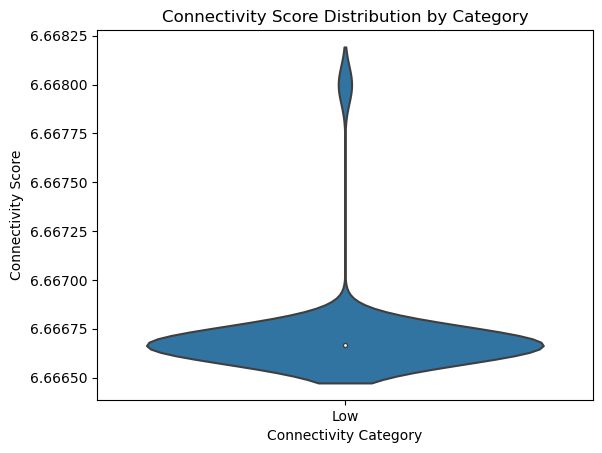

In [188]:
# Connectivity Score Distribution by Category
sns.violinplot(x='predicted_connectivity_category', y='connectivity_score', data=df_unique_locations)
plt.title('Connectivity Score Distribution by Category')
plt.xlabel('Connectivity Category')
plt.ylabel('Connectivity Score')
plt.show()